# TODO
improve mask with std and varience for each pixel compared to average ring

solid angle correction - FM

train difference calculation function


# PLOTTING SCRIPTS

In [1]:
def plot_pulses(q, Sazi_in, skip=1, vminmax=None):
    
    colors = pl.cm.jet(np.linspace(0,1,Sazi_in.shape[0]))

    fig, ax = plt.subplots(1,1)
    for i in range(0, Sazi_in.shape[0], skip):
        ax.plot(q, Sazi_in[i, :], color = colors[i])

    
def plot_mean_pulses(q, Sazi_in):

    fig, ax = plt.subplots(1,1)
    ax.plot(q, np.nanmean(Sazi_in,0))
    
def plot_2d_pulses(q, cellIDs_in, dS, vminmax):
    cells = np.unique(cellIDs)
    fig, ax = plt.subplots(1,1)
    ax.pcolor(q, cells[:175], dS[:175,:], cmap='bwr',vmin=vminmax[0], vmax=vminmax[1])



# IMPORTS

In [2]:
import os
import sys
import h5py as h5
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import pylab as pl


# LOAD RUN

In [3]:
def load_data_filipe(file_inp, file_laser,norm=True, qnorm=[12,14]):
    
    #read in scattering data
    with h5.File(file_inp, 'r') as f:
        Sazi = np.asarray(f['entry_1']['radialavg'])
        q = np.asarray(f['entry_1']['q'])
        cellID = np.asarray(f['entry_1']['cellId'][:,0]).squeeze()
        pulseID = np.asarray(f['entry_1']['pulseId'])
        trainID = np.asarray(f['entry_1']['trainId'])
    
    # read in laser data
    with h5.File(file_laser, 'r') as f:
        laser_on = np.asarray(f['entry_1']['laser_on'])
        laser_train_id = np.asarray(f['entry_1']['trainId'])
    


    t=0
    for i in range(len(cellID)-1):
        if cellID[i]<cellID[i+1]:
            train = trainID[t]
        elif cellID[i]>cellID[i+1]:
            t = t+1
            train=trainID[t]

            
    #Pretty close, but misses some switching
    #pump = trainID%2 #(np.random.random(len(cellID))>0.5)#
    
    
    #copy train ids for every pulse
    pump = trainID[:]
    
    #for each train id
    for i, tid in enumerate(laser_train_id):
        #where the train id of the pulse is equal to the current train id, 
        #set it to whatever the laser state is
        pump[np.where(pump==tid)] = laser_on[i]


        
    
    cellIDs = cellID[:Sazi.shape[0]]
    pulseIDs = pulseID[:Sazi.shape[0]]
    pumps = pump[:Sazi.shape[0]]
    pulseIDs = pulseID[:Sazi.shape[0]]
    trainIDs = trainID[:Sazi.shape[0]]
    
    if norm:
        sum_norm = np.nansum(np.abs(Sazi[:,np.logical_and(q>qnorm[0], q<qnorm[1])]),1)
        for i in range(Sazi.shape[0]):
            Sazi[i,:] = Sazi[i,:]/sum_norm[i]
        
        
    return Sazi, q, cellIDs, pumps, pulseIDs, trainIDs

In [4]:

run = 'r0151'

file_filipe1 = f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/{run}_proc_radavg.h5'
file_filipe2 = f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/{run}_proc_laser.h5'


Sazi_raw, q, cellID_raw, pump_raw, pulseIDs_raw, trainIDs_raw = load_data_filipe(file_filipe1,file_filipe2, qnorm=[14,16])




# DUD PULSE FILTER

In [5]:


def filter_dud_pulses(Sazi_in, cellID_in, pump_in, pulseIDs_in, trainIDs_in):
    
    # sum of the absolute scattering curves for each pulse
    sazi_sum_abs = np.nansum(Sazi_in,1)
    
    # locations where the sum is greater then 0
    # if sum is 0, it means means pulse only had nans
    sumgt0_loc = np.where(np.nansum(Sazi_in, axis=1)>0)
    mask_save = np.where(np.nansum(Sazi_in, axis=1)>0, True, False)
    
    # keep curves where sum > 0
    Sazi_out = Sazi_in[sumgt0_loc,:][0]
    cellID_out = cellID_in[sumgt0_loc]
    pump_out = pump_in[sumgt0_loc]
    pulseIDs_out = pulseIDs_in[sumgt0_loc]
    trainIDs_out = trainIDs_in[sumgt0_loc]
    # print filter info
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')

    return Sazi_out, cellID_out, pump_out, pulseIDs_out, trainIDs_out, mask_save

In [6]:
Sazi_df, cellID_df, pump_df , pulseIDs_df, trainIDs_df, mask_df = filter_dud_pulses(Sazi_raw, cellID_raw, pump_raw, pulseIDs_raw, trainIDs_raw)

Starting with 631654 frames.
Filtering 34249 frames.
597405 frames remain.


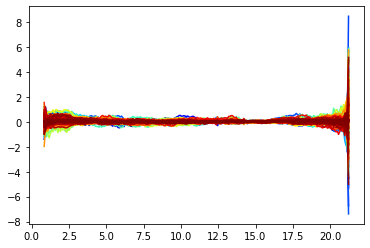

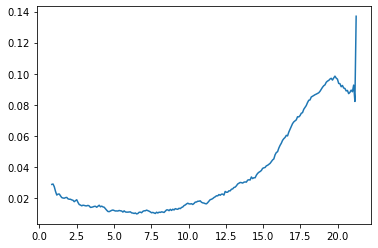

In [7]:
plot_pulses(q, Sazi_df, skip=100)
plot_mean_pulses(q, Sazi_df)

# FILTER ABSOLUTE

In [8]:

def mad(arr, axis=None, keepdims=True):
    median = np.median(arr, axis=axis, keepdims=True)
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad



def filter_abs(Sazi_in, q, q_range, cellID_in, pump_in, pulseIDs_in, trainIDs_in, sigma, mean_bounds):
    
    # mean of the absolute scattering curves for each pulse
    ##sazi_mean_abs = np.nanmean(Sazi_in,1)
    sazi_mean_abs = np.nanmean(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)
    
    # region where the sum is within the mean_bounds range
    mean_mask_loc = np.logical_and(sazi_mean_abs>mean_bounds[0], sazi_mean_abs<mean_bounds[1])
    
    # mean value of all the runs within the mean_bounds range
    sazi_mean_mean = np.nanmean(sazi_mean_abs[mean_mask_loc])
    
    # std value of all the runs within the mean_bounds range
    sazi_mean_std = mad(sazi_mean_abs[mean_mask_loc])
    
    #all_mean = np.nanmeam(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])])
    
    #frame_stds = np.nanstd(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    #plot a histogram of the summed scattering curve values, with mean and std
    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs, bins=500)
    axes.axvline(sazi_mean_mean, color='red')
    axes.axvline(sazi_mean_mean-sazi_mean_std, color='green')
    axes.axvline(sazi_mean_mean+sazi_mean_std, color='green')
    #axes.set_xlim(mean_bounds)
    #axes.axvline(sazi_sum_mean-2*sazi_sum_std, color='purple')
    #axes.axvline(sazi_sum_mean+2*sazi_sum_std, color='purple')
    
    
    # pulses where the summed scattering curve values are within the mean +/- std*sigma
    sum_mean_mask_loc = np.logical_and(sazi_mean_abs>sazi_mean_mean-sazi_mean_std*sigma,
                              sazi_mean_abs<sazi_mean_mean+sazi_mean_std*sigma)
    
    
    # keep curves within this range
    cellID_out = cellID_in[sum_mean_mask_loc]
    pump_out = pump_in[sum_mean_mask_loc]
    Sazi_out = Sazi_in[sum_mean_mask_loc,:]
    pulseIDs_out = pulseIDs_in[sum_mean_mask_loc]
    trainIDs_out = trainIDs_in[sum_mean_mask_loc]
    

    # print filter info
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')
    
    #plot a histogram of the summed scattering curve values, with mean and std after filtering
    
    sazi_mean_abs2 = np.nanmean(Sazi_out[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs2, bins=500)
    
    axes.axvline(sazi_mean_mean, color='red')
    axes.axvline(sazi_mean_mean-sazi_mean_std, color='green')
    axes.axvline(sazi_mean_mean+sazi_mean_std, color='green')
    #axes.axvline(mean-2*std, color='purple')
    #axes.axvline(mean+2*std, color='purple')
    
    return Sazi_out, cellID_out, pump_out, pulseIDs_out, trainIDs_out, sum_mean_mask_loc

Starting with 597405 frames.
Filtering 57990 frames.
539415 frames remain.


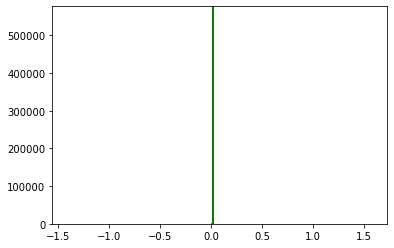

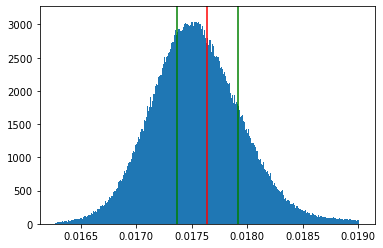

In [9]:
Sazi_mf, cellID_mf, pump_mf, pulseIDs_mf, trainIDs_mf, mask_mf = filter_abs(Sazi_df, q, [0.1, 2.5], cellID_df, pump_df, pulseIDs_df, trainIDs_df, sigma=5, mean_bounds=[0.01,0.04])

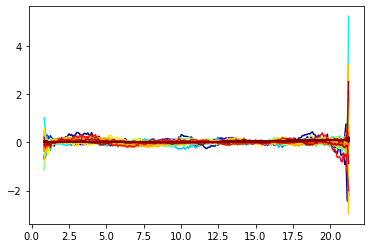

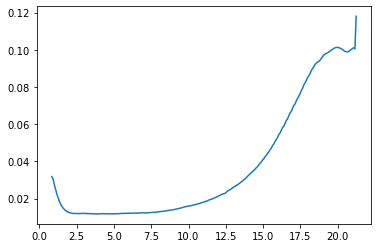

In [10]:
plot_pulses(q, Sazi_mf, skip=10)
plot_mean_pulses(q, Sazi_mf)

# CALCULATE DIFFERENCE

In [11]:
def calc_diff(Sazi_in, q, cellID_in, pump_in):
    
   # print(Sazi_in.shape, cellID_in.shape, pump_in.shape)
    
    
    cells = np.unique(cellID_in)
    #print(cells.shape)
    S_on = np.zeros([len(cells), len(q)])
    S_off = np.zeros([len(cells), len(q)])
    for i in range(cells.shape[0]):
        S_on[i,:] = np.nanmean(Sazi_in[np.logical_and(pump_in==1, cellID_in==cells[i]),:],0)    
        S_off[i,:] = np.nanmean(Sazi_in[np.logical_and(pump_in==0, cellID_in==cells[i]),:],0)
    dS = S_on - S_off
    return dS, S_on, S_off


In [12]:
dS, S_on, S_off = calc_diff(Sazi_mf, q, cellID_mf, pump_mf)

# COUNT FRAMES FOR EACH TIMEPOINT

In [13]:
def count_frames_per_tp(cellID_in, pump_in):
    

    # initialize arrays of pulse ids that will hold how many frames we have of that pulse
    counts = np.ones(max(cellID_in))*np.nan
    counts_on = np.ones(max(cellID_in))*np.nan
    counts_off = np.ones(max(cellID_in))*np.nan
    
    # for each pulse id, 
    for cell_id_check in range(max(cellID_in)):
        #count (sum) how many frames have that id
        counts[cell_id_check] = np.nansum( (cellID_in==cell_id_check) )

        
    
    pump_on = pump_in[:]
    
    cellID_pump_on_masked = cellID_in*pump_in
    max_cellID = np.max(cellID_pump_on_masked)
    
    for cell_id_check in range(max(cellID_in)):
        
        counts_on[cell_id_check] = np.nansum( (cellID_pump_on_masked==cell_id_check) )

        
        
    pump_off = pump_in[:]
    loc1 = np.where(pump_in==1)     
    loc0 = np.where(pump_in==0)
    pump_off[loc1]=0
    pump_off[loc0]=1
    
   
    cellID_pump_off_masked = cellID_in*pump_off
    print(cellID_pump_off_masked.max())
    max_cellID = np.max(cellID_pump_off_masked)
    
    for cell_id_check in range(max(cellID_in)):
        
        counts_off[cell_id_check] = np.nansum( (cellID_pump_off_masked==cell_id_check) )


                                                                              
    return counts, counts_on, counts_off

259532986416
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False F

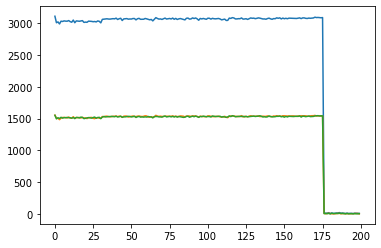

In [14]:
counts, counts_on, counts_off = count_frames_per_tp(cellID_mf, pump_mf)

plt.figure()
plt.plot(counts[1:])
plt.plot(counts_on[1:])
plt.plot(counts_off[1:])

print(counts == counts_on+counts_off)
#print(np.sum(out[0]))

#print(out)

# CALCULATE DIFFERENCE BY TRAIN

In [15]:
def calc_difference_by_train():
    pass

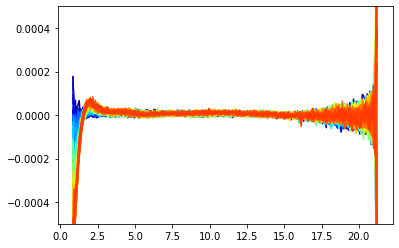

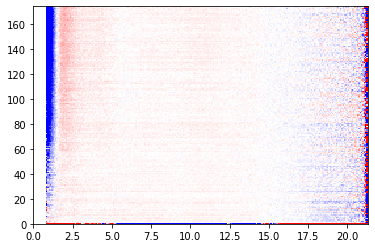

In [16]:
cells = np.unique(cellID_mf)
colors = pl.cm.jet(np.linspace(0,1,dS.shape[0]))
#dS_filt =PLOT dS[mask_std,:]

fig, ax = plt.subplots(1,1)
for i in range(dS.shape[0]-30):
    ax.plot(q, dS[i+3,:].T, color = colors[i])
    ax.set_ylim([-.0005,.0005])
    

cmin = -0.0002
cmax = 0.0002
    
fig, ax = plt.subplots(1,1)
ax.pcolor(q, cells[:175], dS[:175], cmap='bwr',vmin=cmin, vmax=cmax)



In [17]:
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/dS_run{run}.npy', dS)
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/qs_run{run}.npy', q)
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/counts_on_run{run}.npy', counts_on)
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/counts_off_run{run}.npy', counts_off)


# Frames

In [18]:
from extra_data import RunDirectory 
import extra_geom

In [19]:
run_frames = RunDirectory(path=f'/gpfs/exfel/d/raw/SPB/202202/p003046/{run}') 

In [20]:
mask_file = '/home/alfredo/p003046/usr/Shared/alfredo/xfel3046/mask/newer_mask.h5'

with h5.File(mask_file,'r') as f:
    mask = np.asarray(f['combined_mask'])

geom = extra_geom.AGIPD_1MGeometry.from_crystfel_geom('/home/alfredo/p003046/usr/Shared/alfredo/xfel3046/geometry/agipd_september_2022_v03.geom')

In [21]:
print(mask_df.shape)
print(mask_mf.shape)

(631654,)
(597405,)


In [22]:
print(mask_df[:200])
print(mask_df.shape)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [23]:
print(mask_mf[:200])
print(mask_mf.shape)

[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  T

In [24]:
assemask, centremask = geom.position_modules_fast(mask)

In [25]:
path = f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/vds/proc/{run}_proc.cxi'                        


# DO NOT LOAD ALL THE FRAMES, they are too many
chunk_start = 0
chunk_end = 200

#_____________________:loop for chunks of data 
with h5.File(path,'r') as vds_file:
    dataset = vds_file['entry_1']['data_1']['data']
    print(dataset.shape)
    data = dataset[chunk_start:chunk_end,:,:,:]

(631654, 16, 512, 128)


In [26]:
assem, centre = geom.position_modules_fast(data)

In [35]:
frame_nr = 180

print(mask_df[frame_nr])

False


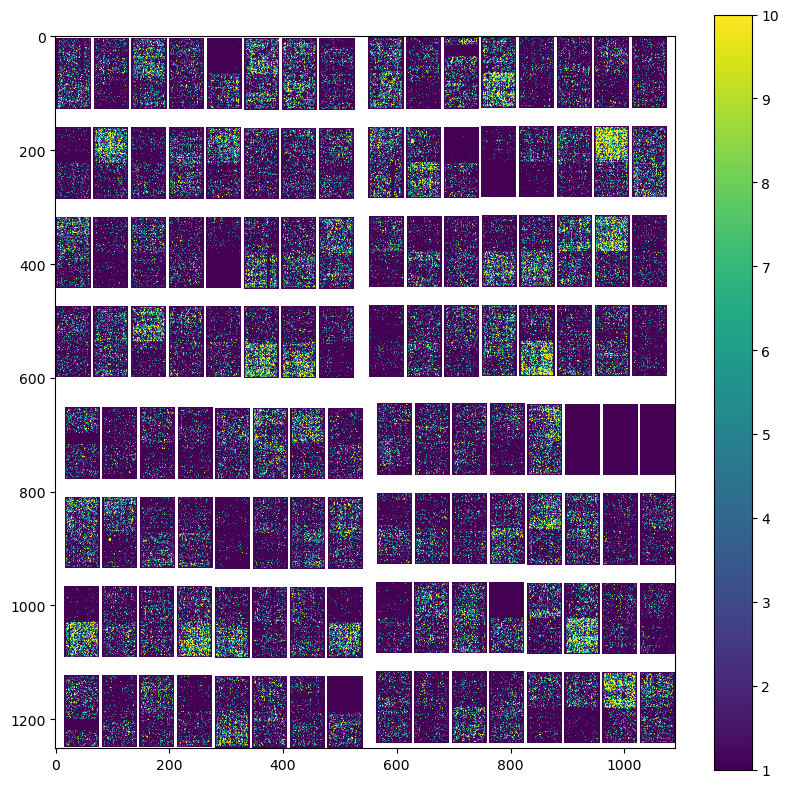

In [37]:
fig = plt.figure(figsize= (10,10), dpi =100)

plt.imshow(assemask*assem[frame_nr], vmin = 1e0, vmax =1e1); plt.colorbar() 

In [56]:
frame_nr = 37

print(mask_df[frame_nr])
print(mask_mf[frame_nr])

True
False


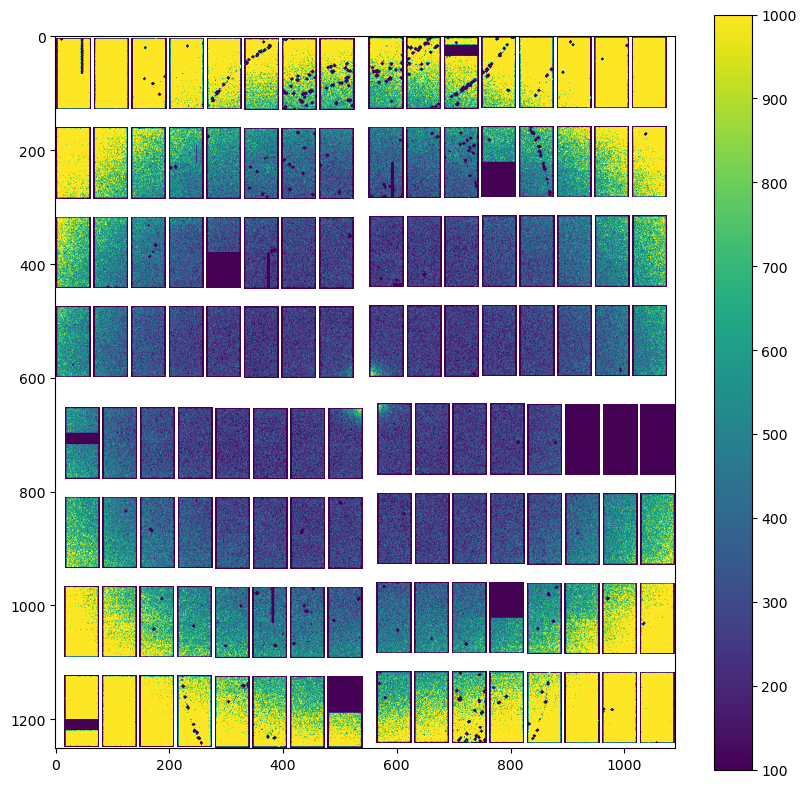

In [58]:
fig = plt.figure(figsize= (10,10), dpi =100)

plt.imshow(assemask*assem[frame_nr], vmin = 1e2, vmax =1e3); plt.colorbar() 

In [59]:
frame_nr = 40

print(mask_df[frame_nr])
print(mask_mf[frame_nr])

True
True


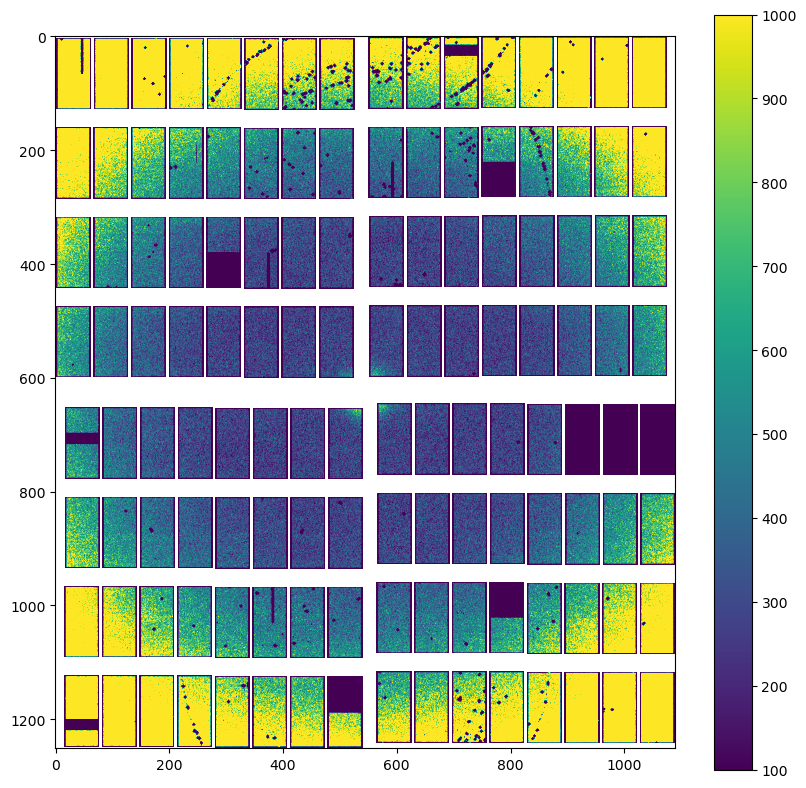

In [61]:
fig = plt.figure(figsize= (10,10), dpi =100)

plt.imshow(assemask*assem[frame_nr], vmin = 1e2, vmax =1e3); plt.colorbar() 